# Exploração de um espaço 2D gerado por uma rede neural


Modelo

In [1]:
import torch
from torch import nn

class Model(nn.Module):
    '''Modelo para classificação de dígitos.'''
    def __init__(self):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=2)
        )

        self.pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(16, 2)
        self.fc2 = nn.Linear(2, 10)

    def forward(self, x):
        x = self.convs(x)
        x = self.pool(x)
        # Transformação do tensor de tamanho bs x 10 x 1 x 1 para bs x 10
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

model = Model()

# OBTENÇÃO DO DATASET

Para obter o dataset MNIST desejado, foi utilizado o script dataset.py com o uso da função load_mnist, a qual depende tanto da classe Subset quanto da função transform_mnist para transformar os dados do formato PIL para array NumPy e de array NumPy para tensor, assim como realizar a normalização e adição de mais um canal.

Com isso, o método load_mnist obtém um subconjunto aleatório de 1000 imagens do dataset MNIST, com o conjunto de treinamento e validação já estando separados (1000 imagens em cada conjunto):

In [102]:
import dataset

ds_train, ds_valid = dataset.load_mnist()

# TREINAMENTO

Com o modelo criado e obtidos os datasets de treino e validação, é realizado o treinamento do modelo.

Foi utilizado um script de treinamento disponibilizado na disciplina (_train.py_)



### Treinamento por 35 épocas


Primeiro foi realizado o treinamento do modelo por 35 épocas, chegando a uma acurácia de 64% com os seguintes parâmetros:

* Batch Size = 8
* Learning Rate = 0.05

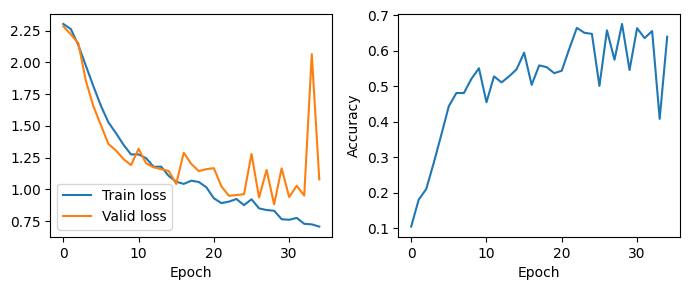

In [78]:
import train # Importação do script de treinamento disponibilizado

logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=35, lr=0.05) # Execução do treinamento

### Resultados obtidos após 35 épocas

In [79]:
print(f"Train Loss na última época: {logger[-1][1]}")
print(f"Validation Loss na última época: {logger[-1][2]}")
print(f"Accuracy na última época: {logger[-1][3]}")

Train Loss na última época: 0.7060422897338867
Validation Loss na última época: 1.0778647661209106
Accuracy na última época: 0.6399999856948853


### Salvando o modelo após 35 épocas

In [80]:
checkpoint = {
    'params':{
        'bs':8,
        'num_epochs':35,
        'lr':0.05
    },
    'model':model.state_dict()
}
torch.save(checkpoint, 'mnist_model_epoch35.pt')

### Treinamento por mais 20 épocas

Depois, o modelo foi treinado por mais 20 épocas, alterando o Learning Rate para 0.0005

Deste modo, foi possível obter uma acurácia mais satisfatória de aproximadamente 71%

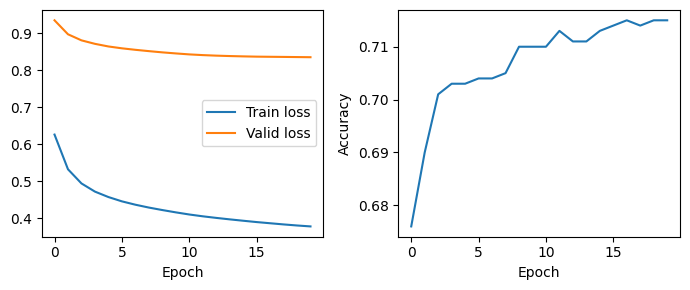

In [87]:
logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=20, lr=0.0005) # Execução do treinamento

### Resultados obtidos após 35 épocas (lr=0.05) + 20 épocas (lr=0.0001)

In [89]:
print(f"Train Loss na última época: {logger[-1][1]}")
print(f"Validation Loss na última época: {logger[-1][2]}")
print(f"Accuracy na última época: {logger[-1][3]}")

Train Loss na última época: 0.37826278805732727
Validation Loss na última época: 0.8356934785842896
Accuracy na última época: 0.7149999737739563


### Salvando o modelo final

O modelo é salvo no arquivo 'mnist_model_treinamento_final.pt'

In [90]:
checkpoint = {
    'params':{
        'bs':8,
        'num_epochs':55,
        'lr':0.0001
    },
    'model':model.state_dict()
}
torch.save(checkpoint, 'mnist_model_treinamento_final.pt')

### Carregando o modelo final obtido após as 55 (35 + 20) épocas de treinamento,

In [97]:
checkpoint = torch.load('mnist_model_treinamento_final.pt')
model = Model()
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

# ANÁLISE DA CAMADA GARGALO



### Função para obtenção das ativações na camada de gargalo (fc1)

Para a visualização das ativações no espaço 2D da camada de gargalo, foi criada uma função a qual recebe o modelo utilizado e o dataset de treinamento, a partir disso, a última camada do modelo é transformada em uma camada identidade, desta forma, não ocorrem ativações na última camada e as últimas ativações visíveis serão as da camada de gargalo, a função então retoran  os pares que podem ser plotados em um gráfico de dispersão, junto dos labels representando a classe de cada uma dessas ativações

In [98]:
def get_2d_activations(model, dataset):
    '''
    Função para obtenção das ativações da camada gargalo do modelo

    Parâmetros:
    model -> Modelo de CNN utilizado
    dataset -> Dataset que será aplicado ao modelo para obtenção das ativações

    Saída:
    activations -> tensor [1000, 2], representando as ativações para cada imagem
    labels -> tensor [1000], representando as classes de cada imagem
    '''
    data = torch.stack([img for img, _ in dataset]) # Agrupamento das imagens em um novo tensor
    target = [target for _, target in dataset] # Agrupamento das calsses em uma lista
    model.eval() # Coloca o modelo para validação
    model.fc2 = nn.Identity() # Transforma a última camada do modelo em uma camada identidade para que ela não interfira nas ativações, mantendo as ativações da camada gargalo para o output final do modelo

    with torch.no_grad():
        activations = model(data) # Aplicação do modelo em todas as imagens do dataset
        labels = target # Obtenção das classes para serem usadas

    return activations, labels

### Plot dos resultados obtidos

São obtidas as ativações de cada imagem e o label correspondente, utilizando matplot lib é possível analisar como esses pontos ficam distribuídos no espaço

Text(0, 0.5, 'Eixo Y')

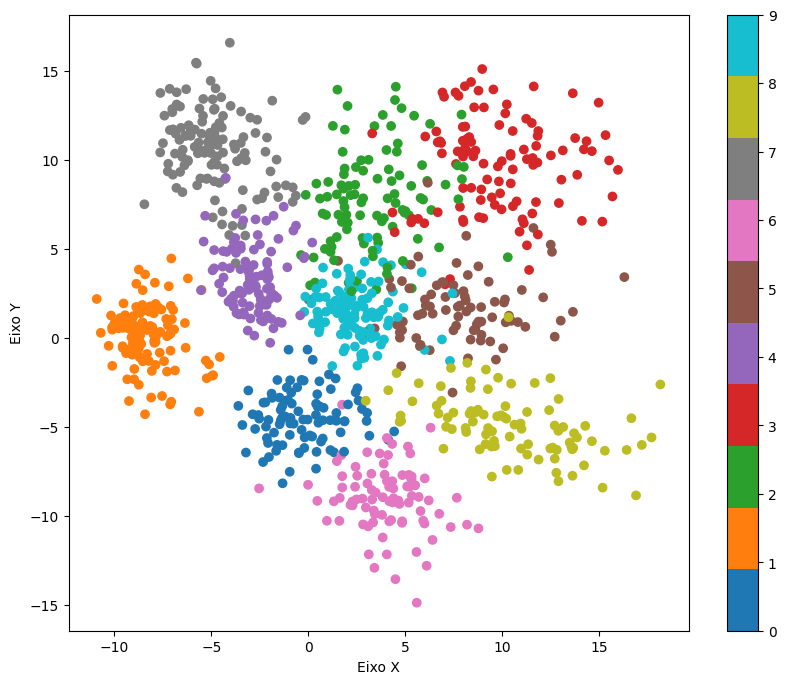

In [101]:
import matplotlib.pyplot as plt

activations, labels = get_2d_activations(model, ds_train)

# Plot das ativações 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(activations[:, 0], activations[:, 1], c=labels, cmap='tab10', alpha=1)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Eixo X')
plt.ylabel('Eixo Y')
#plt.title('Ativações 2D do Modelo no Conjunto de Treinamento MNIST')